In [13]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split
from PIL import Image
import matplotlib.pyplot as plt
# torch.manual_seed(17)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/COMPUTER_VISION/PROJECT

cpu


In [14]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0.4356, std=0.2399)
])

In [15]:
BATCH_SIZE = 32

trainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', transform=transform, loader=Image.open)

true_train_set, validation_train_set = random_split(trainset, (0.85, 0.15))

trainloader = torch.utils.data.DataLoader(true_train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin
validloader = torch.utils.data.DataLoader(validation_train_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=transform, loader=Image.open)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin

print(f'entire train folder: {len(trainset)}, entire test folder: {len(testset)}, splitted trainset: {len(true_train_set)},  splitted validset: {len(validation_train_set)}')

entire train folder: 1500, entire test folder: 2985, splitted trainset: 1275,  splitted validset: 225


In [16]:
# abbiamo verificato che su un'altro dataset (MNIST) il training funzionasse
'''
transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST('.', transform=transforms,  train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST('.', transform=transforms, train=False, download=True)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
'''

"\ntransforms = torchvision.transforms.Compose([\n        torchvision.transforms.ToTensor(),\n        torchvision.transforms.Normalize((0.1307,), (0.3081,))\n])\n\ntrainset = torchvision.datasets.MNIST('.', transform=transforms,  train=True, download=True)\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)\n\ntestset = torchvision.datasets.MNIST('.', transform=transforms, train=False, download=True)\nvalidloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)\n"

In [17]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
                torch.nn.ReLU()
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(32*12*12, 15),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.classifier(self.conv(x))


model = CNN().to(device)

In [18]:
def initialize_weigths_and_bias(m):
  if (type(m) == torch.nn.Linear) or (type(m) == torch.nn.Conv2d):
      torch.nn.init.constant_(m.bias.data, 0) # initialize weights
      torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.01)
  

model.apply(initialize_weigths_and_bias)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=15, bias=True)
    (2): Softmax(dim=1)
  )
)

In [19]:
# Checking initialization printing mean, std, max biases in the classifier fully connected layer

model.classifier[1].weight.mean(), model.classifier[1].weight.std(), model.classifier[1].bias.max()

(tensor(7.6481e-06, grad_fn=<MeanBackward0>),
 tensor(0.0100, grad_fn=<StdBackward0>),
 tensor(0., grad_fn=<MaxBackward1>))

In [20]:
# Checking initialization printing mean, std, max biases in the first convolution layer

model.conv[3].weight.mean(), model.conv[3].weight.std(), model.conv[3].bias.max()

(tensor(0.0003, grad_fn=<MeanBackward0>),
 tensor(0.0102, grad_fn=<StdBackward0>),
 tensor(0., grad_fn=<MaxBackward1>))

In [21]:
def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return correct/len(dataloader.dataset)

In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = torch.nn.CrossEntropyLoss()

In [23]:
epochs = 5
losses = []
for epoch in range(epochs):
    print(f"Epoch: {epoch}, Test accuracy: {get_accuracy(model, validloader)}")
    model.train()
    running_loss = 0
    for x, y in iter(trainloader):
        x = x.to(device)
        y = y.to(device)
        out=model(x)
        l=loss(out, y)
        running_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    losses.append(running_loss/len(trainloader.dataset))
print(f"Final accuracy: {get_accuracy(model, validloader)}")

Epoch: 0, Test accuracy: 0.04888888821005821
Epoch: 1, Test accuracy: 0.035555556416511536
Epoch: 2, Test accuracy: 0.035555556416511536
Epoch: 3, Test accuracy: 0.035555556416511536
Epoch: 4, Test accuracy: 0.035555556416511536
Final accuracy: 0.035555556416511536


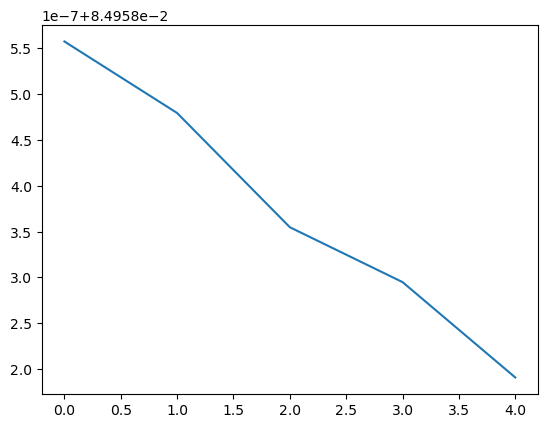

In [24]:
plt.plot(losses)